This notebook generates all the figure we are using for the AGU poster. 

### imports and setup

In [1]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

In [2]:
from utils.jraph_training import train_and_evaluate_with_data, create_dataset, evaluate_model, rollout
# from utils.jraph_models import MLPGraphNetwork
from utils.jraph_data import print_graph_fts
from utils.jraph_vis import plot_predictions
from utils.hyperparam_tuning import remove_bad_trials, get_best_trial_config, get_best_trial_workdir
import ml_collections
import optuna 
from flax import linen as nn
from functools import partial
from datetime import datetime
import os 
import tempfile
import matplotlib.pyplot as plt 
import numpy as np 

import jax
from utils.jraph_training import create_dataset, create_model, create_optimizer
from clu import checkpoint
from clu import parameter_overview
from flax.training import train_state



/Users/miamirabelli/Desktop/GNN Research/lorenzGNN/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# set up logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

### helper functions

In [4]:
def load_model_with_checkpoint(config, workdir, ckpt_path, datasets):
    # Create and initialize the network.
    logging.info('Initializing network.')
    rng = jax.random.key(0)
    rng, init_rng = jax.random.split(rng)
    sample_input_window = datasets["train"]["inputs"][0]
    init_net = create_model(config, deterministic=True)
    params = jax.jit(init_net.init)(init_rng, sample_input_window)
    parameter_overview.log_parameter_overview(params) # logs to logging.info

    # Create the optimizer.
    tx = create_optimizer(config)

    # Create the training state.
    net = create_model(config, deterministic=True) # deterministic because we are doing evaluation, we don't want dropout (that's only for training)
    state = train_state.TrainState.create(
        apply_fn=net.apply, params=params, tx=tx
    )

    # Set up checkpointing of the model.
    # The input pipeline cannot be checkpointed in its current form,
    # due to the use of stateful operations.
    checkpoint_dir = os.path.join(workdir, 'checkpoints')
    ckpt = checkpoint.Checkpoint(checkpoint_dir, 
                                 max_to_keep=config.max_checkpts_to_keep)
    state = ckpt.restore(state=state, checkpoint=ckpt_path)

    return state

### model setup (data, configs, load checkpoints, etc)

In [5]:
# create config for the lorenz system where x1 and x2 have similar dynamics
config_x1x2similar = ml_collections.ConfigDict()

config_x1x2similar.n_samples=10_000
config_x1x2similar.input_steps=1
config_x1x2similar.output_delay=8 # predict 24 hrs into the future 
config_x1x2similar.output_steps=4
config_x1x2similar.timestep_duration=3 # equivalent to 3 hours
# note a 3 hour timestep resolution would be 5*24/3=40
# if the time_resolution is 120, then a sampling frequency of 3 would achieve a 3 hour timestep 
config_x1x2similar.sample_buffer = -1 * (config_x1x2similar.input_steps + config_x1x2similar.output_delay + config_x1x2similar.output_steps - 1) # negative buffer so that our sample input are continuous (i.e. the first sample would overlap a bit with consecutive samples) 
    # number of timesteps strictly between the end 
    # of one full sample and the start of the next sample
config_x1x2similar.time_resolution=120 # the number of 
            # raw data points generated per time unit, equivalent to the 
            # number of data points generated per 5 days in the simulation
config_x1x2similar.init_buffer_samples=100
config_x1x2similar.train_pct=0.7
config_x1x2similar.val_pct=0.2
config_x1x2similar.test_pct=0.1
config_x1x2similar.K=36
config_x1x2similar.F=8
config_x1x2similar.c=10
config_x1x2similar.b=10
config_x1x2similar.h=1
config_x1x2similar.seed=42
config_x1x2similar.normalize=True
config_x1x2similar.fully_connected_edges=False
config_x1x2similar.max_checkpts_to_keep = None # None means keep all

# Optimizer.
config_x1x2similar.optimizer = "adam"
config_x1x2similar.learning_rate = 0.0008

# Data params that are used in training 
config_x1x2similar.output_steps = 4

# Training hyperparameters.
config_x1x2similar.batch_size = 1 # variable currently not used
config_x1x2similar.epochs = 200
config_x1x2similar.log_every_epochs = 5
config_x1x2similar.eval_every_epochs = 5
config_x1x2similar.checkpoint_every_epochs = 10

# GNN hyperparameters.
config_x1x2similar.model = 'MLPBlock'
config_x1x2similar.dropout_rate = 2e-5
config_x1x2similar.skip_connections = False # This was throwing a broadcast error in add_graphs_tuples_nodes when this was set to True
config_x1x2similar.layer_norm = False # TODO perhaps we want to turn on later
config_x1x2similar.activation = "leaky_relu"

config_x1x2similar.pred_x1 = True
config_x1x2similar.pred_x2 = True

if config_x1x2similar.pred_x1 and config_x1x2similar.pred_x2:
    output_layer = 2
else:
    output_layer = 1

# choose the hidden layer feature size using powers of 2 
config_x1x2similar.edge_features = (
    2**2,
    2**2,
)
config_x1x2similar.node_features = (
    2**8,
    2**3,
    output_layer,
)
# note the last feature size will be the number of features that the graph predicts
config_x1x2similar.global_features = None

In [6]:
# generate dataset 
datasets_x1x2similar = create_dataset(config_x1x2similar)
print_graph_fts(datasets_x1x2similar['train']['inputs'][0][0])

Number of nodes: 36
Number of edges: 180
Node features shape: (36, 2)
Edge features shape: (180, 1)
Global features shape: (1, 1)


In [10]:
ckpt_num = 13
workdir_x1x2similar = "experiments/outputs/X1_X2_similar_dynamics"
ckpt_path_x1x2similar = os.path.join(workdir_x1x2similar, 
                                     f"checkpoints/ckpt-{ckpt_num}")

state_x1x2similar = load_model_with_checkpoint(config_x1x2similar, 
                                               workdir_x1x2similar, 
                                               ckpt_path_x1x2similar,
                                               datasets_x1x2similar)

### run evaluation over metric suite

In [11]:
eval_metrics_dict = evaluate_model(
    state = state_x1x2similar,
    n_rollout_steps = config_x1x2similar.output_steps,
    datasets = datasets_x1x2similar,
    splits = ["val", "test"],
    all_metrics = True
)

In [13]:
print("Mean Squared Error:", eval_metrics_dict["val"].mse.compute())
print("Mean Bias:", eval_metrics_dict["val"].mb.compute())
print("Mean Error:", eval_metrics_dict["val"].me.compute())
print("Root Mean Squared Error:", eval_metrics_dict["val"].rmse.compute())
print("Centered Root Mean Squared Error:", eval_metrics_dict["val"].crmse.compute())
print("Normalized Mean Bias:", eval_metrics_dict["val"].nmb.compute())
print("normalized mean error:".title(), eval_metrics_dict["val"].nme.compute())
print("fractional bias:".title(), eval_metrics_dict["val"].fb.compute())
print("fractional error:".title(), eval_metrics_dict["val"].fe.compute())
print("correlation coefficient (R):".title(), eval_metrics_dict["val"].r.compute())
print("R^2:".title(), eval_metrics_dict["val"].r2.compute())
print("Index of agreement:".title(), eval_metrics_dict["val"].d.compute())
print("Pearson correlation:".title(), eval_metrics_dict["val"].pearson.compute())


Mean Squared Error: 1248520800.0
Mean Bias: -448.4759
Mean Error: 449.81015
Root Mean Squared Error: 1106.545
Centered Root Mean Squared Error: 1010.5472
Normalized Mean Bias: 0.79897076
Normalized Mean Error: 10.833274
Fractional Bias: 1.462804
Fractional Error: 42.060753
Correlation Coefficient (R): 0.17327541


AttributeError: 'EvalMetricsSuite' object has no attribute 'r2'

### plot time series 

In [ ]:
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22) 
plt.rc('axes', labelsize=35)
plt.rcParams["font.size"] = "22"

Checkpoint directory: experiments/outputs/X1_X2_similar_dynamics_2/checkpoints


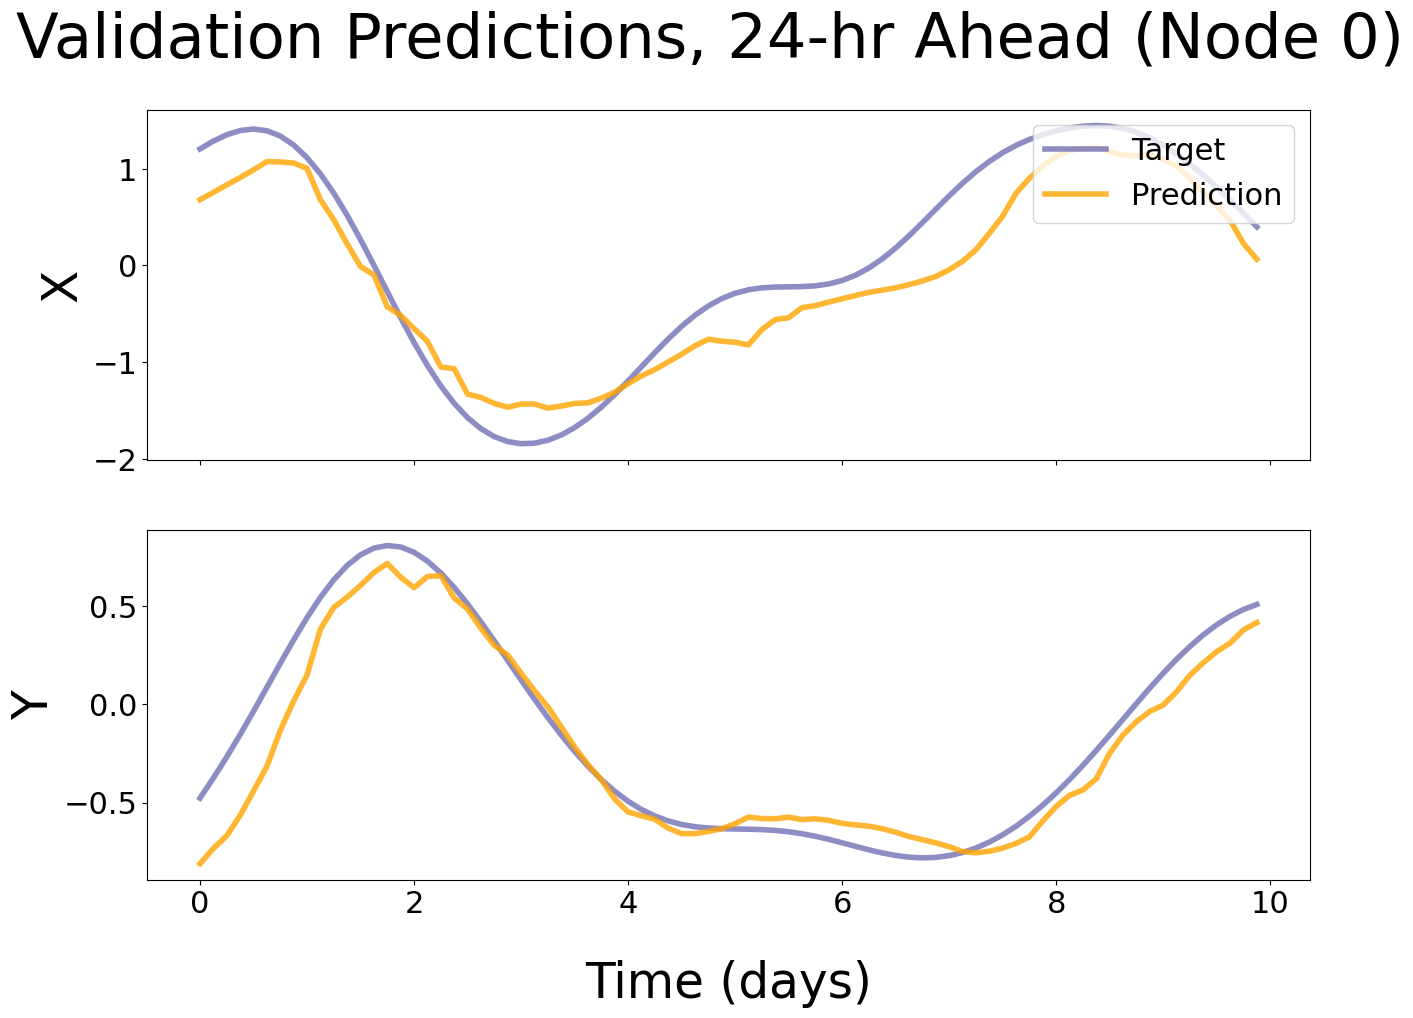

In [ ]:
plot_predictions(
    config=config_x1x2similar,
    workdir=workdir_x1x2similar,
    plot_ith_rollout_step=0, # 0 indexed # for this study, we have a 4-step rollout 
    node=0, # 0-indexed 
    plot_mode="val", # i.e. "train"/"val"/"test"
    datasets=datasets_x1x2similar,
    plot_days=10, 
    title="Validation Predictions, 24-hr Ahead (Node 0)"
)


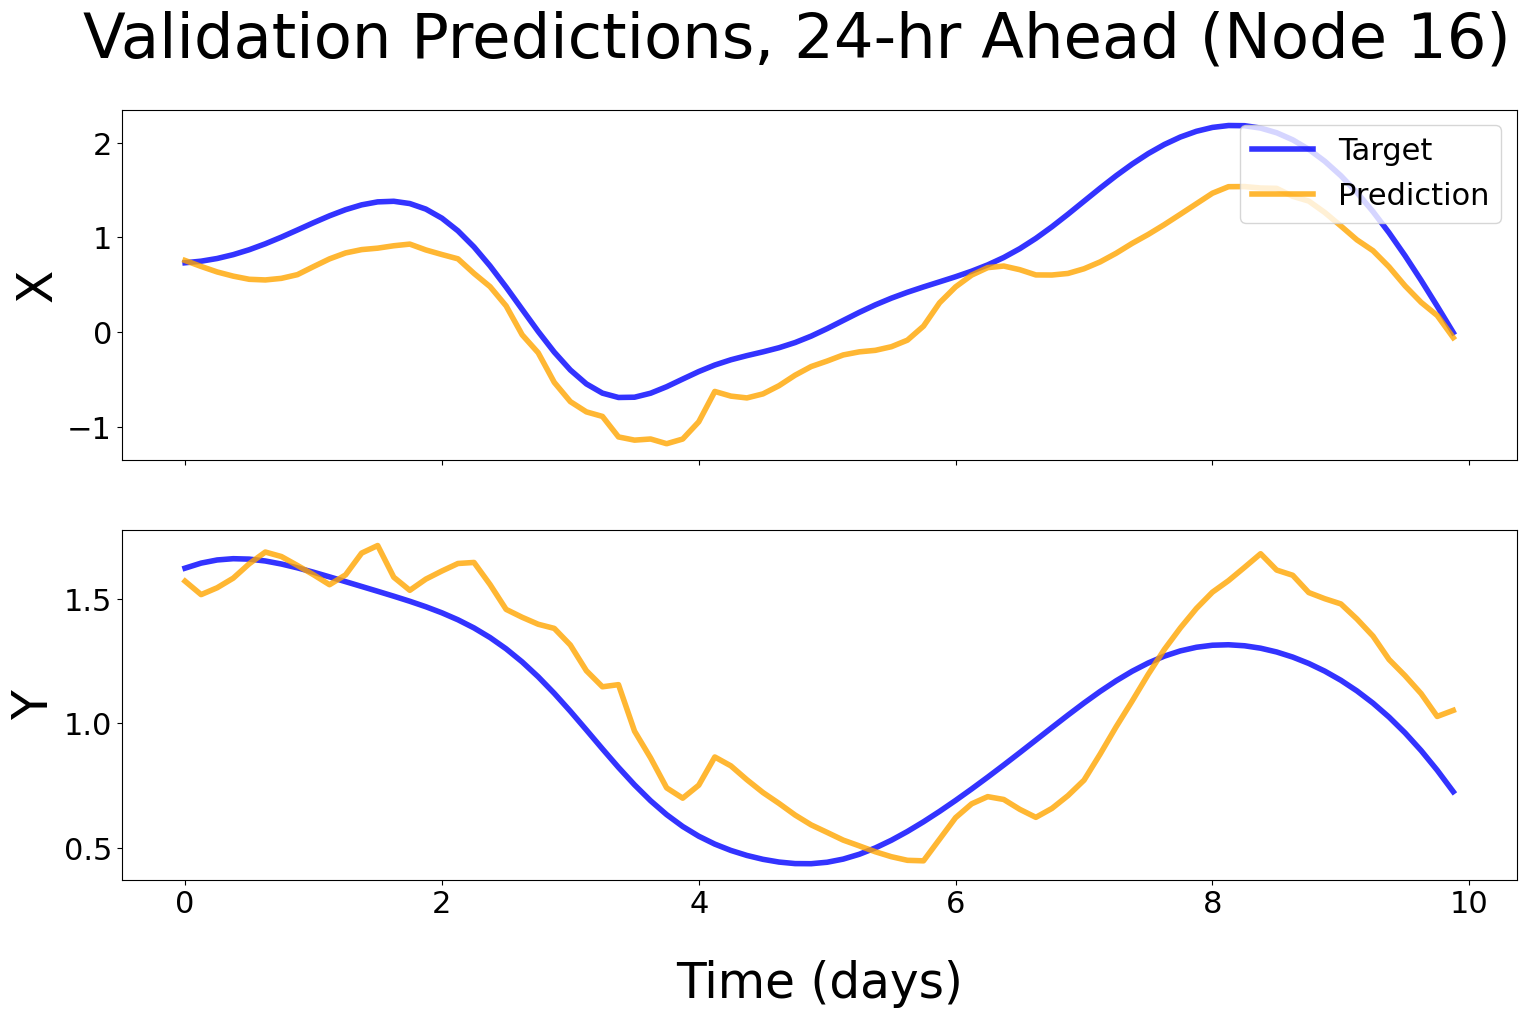

In [ ]:
plot_predictions(
    config=config_x1x2similar,
    workdir=workdir_x1x2similar,
    plot_ith_rollout_step=0, # 0 indexed # for this study, we have a 4-step rollout 
    node=16, # 0-indexed 
    plot_mode="val", # i.e. "train"/"val"/"test"
    datasets=datasets_x1x2similar,
    plot_days=10, 
    title="Validation Predictions, 24-hr Ahead (Node 16)"
)


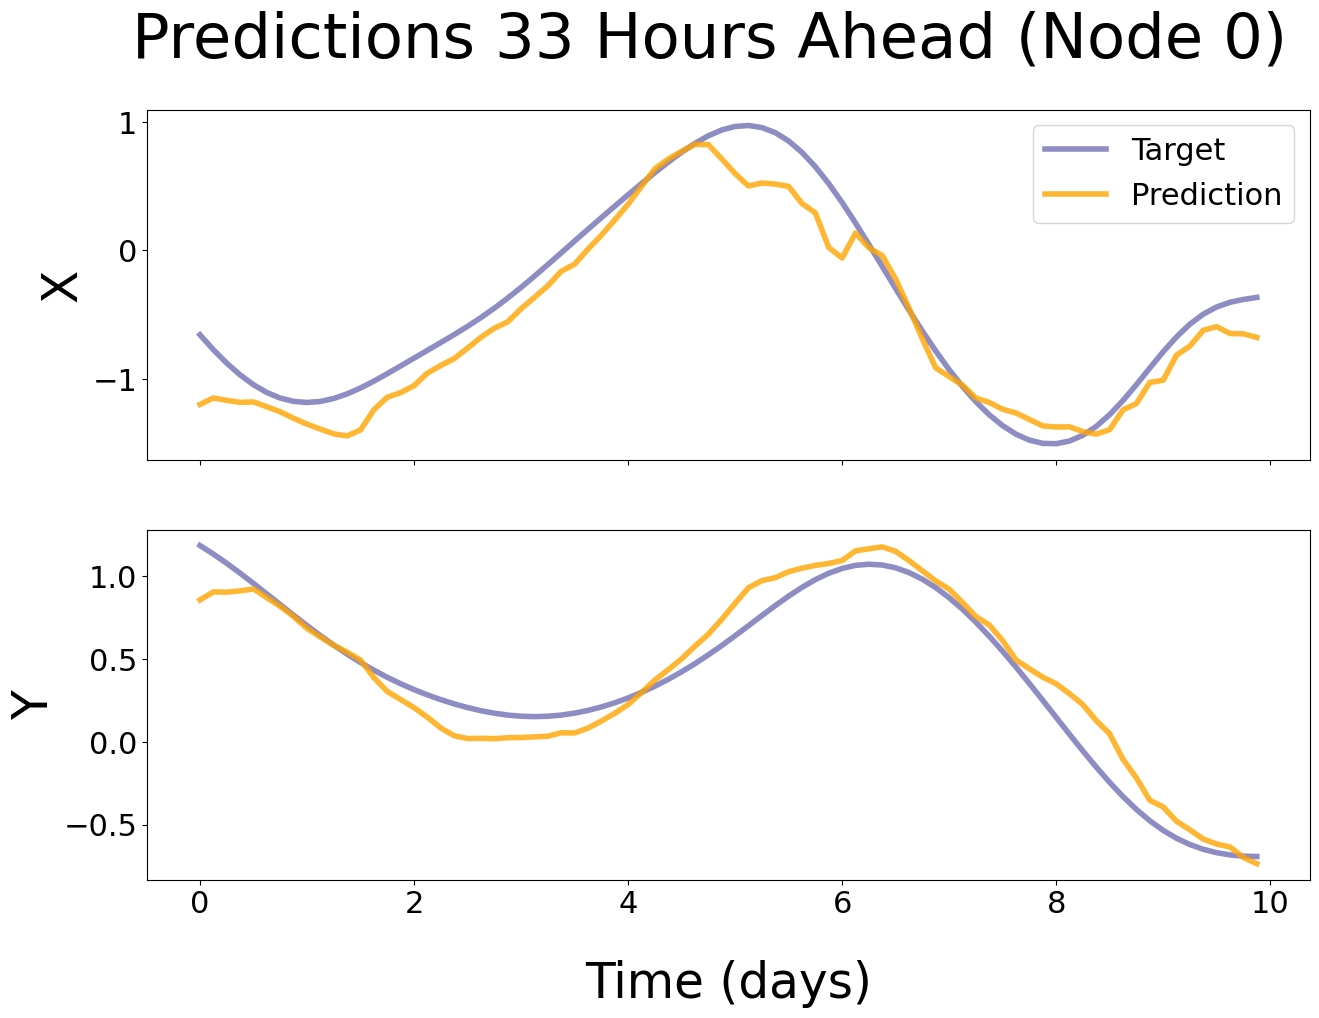

In [ ]:
plot_predictions(
    config=config_x1x2similar,
    workdir=workdir_x1x2similar,
    plot_ith_rollout_step=3, # 0 indexed # for this study, we have a 4-step rollout 
    node=0, # 0-indexed 
    plot_mode="val", # i.e. "train"/"val"/"test"
    datasets=datasets_x1x2similar,
    plot_days=10, 
    title="Predictions 33 Hours Ahead (Node 0)"
)

try plotting multiple rollouts on same plot

In [ ]:
def plot_predictions_multirollout(
    config,
    workdir, # for loading checkpoints 
    node, # 0-indexed 
    plot_mode, # i.e. "train"/"val"/"test"
    datasets=None,
    plot_days=None, # if None, plot entire time series; otherwise plot specified number of days 
    title=''):
    assert plot_mode in ["train", "val", "test"]

    checkpoint_dir = os.path.join(workdir, 'checkpoints')
    assert os.path.exists(checkpoint_dir)

    # samples must be overlapping and consecutive for this plot to really be interpretable the way it is meant 
    assert (
        config.input_steps + config.output_delay + config.output_steps + config.sample_buffer == 1
        )

    # Get datasets, organized by split.
    if datasets is None:
        logging.info('Generating datasets from config because none provided.')
        datasets = create_dataset(config)

    plot_set = datasets[plot_mode]
    input_data = plot_set['inputs']
    target_data = plot_set['targets']
    # n_rollout_steps = config.output_steps

    # Create the evaluation state, corresponding to a deterministic model.
    logging.info('Initializing network.')
    rng = jax.random.key(0)
    rng, init_rng = jax.random.split(rng)
    sample_input_window = input_data[0]
    eval_net = create_model(config, deterministic=True)
    params = jax.jit(eval_net.init)(init_rng, sample_input_window)
    parameter_overview.log_parameter_overview(params) # logs to logging.info

    # Create the optimizer and state.
    # (we don't actually need the optimizer for evaluation, we just need it to create the state)
    tx = create_optimizer(config)
    state = train_state.TrainState.create(
        apply_fn=eval_net.apply, params=params, tx=tx
    )

    # load the checkpoint state
    ckpt = checkpoint.Checkpoint(checkpoint_dir)
    state = ckpt.restore(state) # restore latest checkpoint 

    # get the predictions from the model for the ith step of the rollout and for the specified node
    node_preds_all_rollouts = []
    node_targets = []

    # loop over individual windows in the dataset 
    # TODO try batching to see if its faster? 

    if plot_days is not None:
        plot_count = plot_days * config.time_resolution / 5 / config.timestep_duration
    else:
        plot_count = len(input_data)

    for i, (input_window_graphs, target_window_graphs) in enumerate(zip(
        input_data, target_data)):
        if i >= plot_count:
            break
        pred_nodes_list = rollout(state=state,
                                  input_window_graphs=input_window_graphs,
                                  n_rollout_steps=config.output_steps,
                                #   n_rollout_steps=plot_ith_rollout_step+1, # +1 since plot_ith_rollout_step is 0-indexed
                                  rngs=None) # deterministic during eval
        
        # get the last array of predictions, which will correspond to the ith rollout step that we care about 
        # ith_rollout_pred = pred_nodes_list[plot_ith_rollout_step]
        # node_pred = ith_rollout_pred[node, :] # jnp array with shape (1, 2)
        node_preds_all_rollouts.append([ith_rollout_pred[node, :] for ith_rollout_pred in pred_nodes_list])

        # also grab the target nodes while we're in this loop 
        # ith_rollout_target = target_window_graphs[plot_ith_rollout_step].nodes
        node_target = target_window_graphs[0].nodes[node, :] # jnp array with shape (1, 2)
        node_targets.append(node_target)
        # node_targets.append([ith_rollout_target.nodes[node, :] for ith_rollout_target in target_window_graphs])

    node_preds_all_rollouts = np.array(node_preds_all_rollouts) # shape (len(t_days), output_steps, 2)
    node_targets = np.array(node_targets) # shape (len(t_days), 2)

    # reconstruct timesteps
    steps = np.arange(plot_count)
    # convert timesteps from step index to day 
    t_days = steps * config.timestep_duration * 5 / config.time_resolution 

    # set up plot
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20, 8))
    if title == '':
        fig.suptitle(f"{plot_mode} predictions for node {node}", size=28)
    else:
        fig.suptitle(title, size=28)
    ax0.set_title("X1 (i.e. atmospheric variable) for node {}".format(node),
                  size=20)
    ax1.set_title("X2 (i.e. oceanic variable) for node {}".format(node),
                  size=20)
    plt.xlabel('time (days)', size=16)

    # plot rollout targets
    ax0.plot(
        t_days,
        node_targets[:, 0],
        # s=5,
        alpha=0.8,
        label='targets',
        c='blue')
    ax1.plot(
        t_days,
        node_targets[:, 1], 
        alpha=0.8, 
        label='targets', 
        c='blue')

    # plot predictions
    for i in range(config.output_steps):
        rollout_steps = np.arange(i, plot_count + i)
        t_days_rollout = rollout_steps * config.timestep_duration * 5 / config.time_resolution 
        ax0.plot(
            t_days_rollout,
            node_preds_all_rollouts[:, i, 0],
            # s=5,
            alpha=0.8,
            label=f'rollout {i}')
        ax1.plot(
            t_days_rollout,
            node_preds_all_rollouts[:, i, 1],
            # s=5,
            alpha=0.8,
            label=f'rollout {i}')

    ax0.legend()
    ax1.legend()


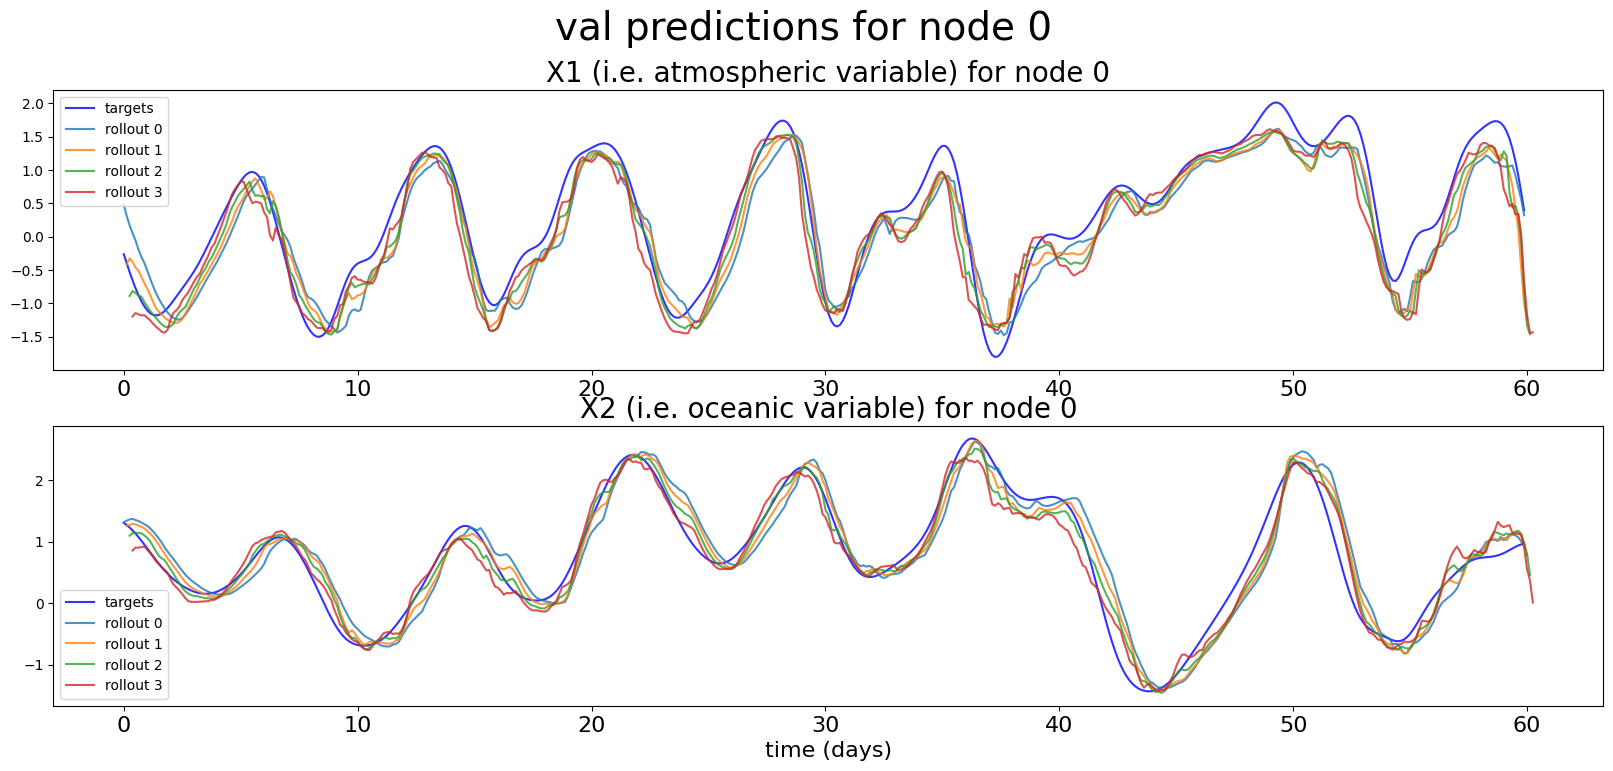

In [ ]:
plot_predictions_multirollout(
    config=config_x1x2similar,
    workdir=workdir_x1x2similar,
    node=0, # 0-indexed 
    plot_mode="val", # i.e. "train"/"val"/"test"
    datasets=datasets_x1x2similar,
    plot_days=60, 
)

### longitudinal plots
original lorenz data, predicted, and difference

In [ ]:
def plot_longitudinal(
    state, 
    config, 
    version, 
    plot_ith_rollout_step, 
    plot_mode, 
    datasets, 
    plot_days,
    title=None,
):
    assert version in ["target", "predicted", "diff"]
    assert plot_mode in ["train", "val", "test"]

    # set up data 
    plot_set = datasets[plot_mode]
    input_data = plot_set['inputs']
    target_data = plot_set['targets']

    plot_count = plot_days * config.time_resolution / 5 / config.timestep_duration

    target_timeseries = []
    pred_timeseries = []
    diff_timeseries = []

    # reconstruct timesteps
    steps = np.arange(plot_count)
    # convert timesteps from step index to day 
    t_days = steps * config.timestep_duration * 5 / config.time_resolution 

    for i, (input_window_graphs, target_window_graphs) in enumerate(zip(
        input_data, target_data)):
        if i >= plot_count:
            break

        if version in ["predicted", "diff"]:
            # get predicted data 
            pred_nodes_list = rollout(state=state,
                                    input_window_graphs=input_window_graphs,
                                    n_rollout_steps=config.output_steps,
                                    rngs=None) # deterministic during eval
            
            # get the last array of predictions, which will correspond to the ith rollout step that we care about 
            ith_rollout_pred = pred_nodes_list[plot_ith_rollout_step]
            pred_timeseries.append(ith_rollout_pred)

        if version in ["target", "diff"]:
            # get original data 
            ith_rollout_target = target_window_graphs[plot_ith_rollout_step].nodes
            target_timeseries.append(ith_rollout_target)

        if version == "diff":
            # get diff
            diff_timeseries.append(ith_rollout_pred - ith_rollout_target) 
    
    if version == "target":
        timeseries_to_plot = np.array(target_timeseries)
    elif version == "predicted":
        timeseries_to_plot = np.array(pred_timeseries)
    elif version == "diff":
        timeseries_to_plot = np.array(diff_timeseries)
    # these have shape (len(t_days), 36, 2)

    lon=np.arange(180,-180,-360/config.K)

    xmin = min(lon)
    xmax = max(lon)
    ymin = min(t_days)
    ymax = max(t_days)

    # create plot
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 14), sharex=True, sharey=True)
    X1 = timeseries_to_plot[:, :, 0]
    X2 = timeseries_to_plot[:, :, 1]

    # set colormaps and min/max values for the color bar 
    if version == "diff":
        cmap1 = "RdBu_r"
        cmap2 = "RdBu_r"
        # vmin = 
    else:
        cmap1 = "PiYG_r"
        cmap2 = "PuOr_r"
    # plot x1
    x1_plot = ax0.imshow(X1,
            extent=[xmin, xmax, ymin, ymax], 
            origin='lower', 
            cmap=cmap1,
            alpha=0.5,
            aspect='auto', 
            vmin=-2,
            vmax=2,
            # vmin=-np.percentile(X1, .9), 
            # vmax=np.percentile(X1, .9)
            )
    fig.gca().invert_yaxis() 
    
    # plot x2
    x2_plot = ax1.imshow(X2,
            extent=[xmin, xmax, ymin, ymax], 
            origin='lower', 
            cmap=cmap2,
            alpha=0.5,
            aspect='auto', 
            vmin=-2,
            vmax=2,
            # vmin=-np.percentile(X2, .9), 
            # vmax=np.percentile(X2, .9)
            )
    fig.gca().invert_yaxis() 
    
    ax1.set_ylabel('Time (days)', fontsize=35)
    ax1.yaxis.set_label_coords(-0.1,1) # move to be centered vertically 

    ax1.set_xlabel('Longitude', fontsize=35, labelpad=20)
    plt.rc('axes', labelsize=35)
    plt.rc('xtick', labelsize=22)
    plt.rc('ytick', labelsize=22)
    fig.colorbar(x1_plot).set_label(label='$X_k$',
                             size=35,
                             rotation=270,
                             labelpad=40)
    fig.colorbar(x2_plot).set_label(label='$Y_k$',
                             size=35,
                             rotation=270,
                             labelpad=40)
    if title is not None:
        fig.suptitle(title, size=45)
    else:
        if version == "target":
            fig.suptitle(
                'Lorenz 96 Model, Longitudinal Profile',
                size=45)
        elif version == "predicted":
            fig.suptitle(
                'Predicted Lorenz 96 Dynamics, Longitudinal Profile',
                size=45)
        elif version == "diff":
            fig.suptitle(
                'Lorenz 96 Difference in Prediction, Longitudinal Profile',
                size=45)
    plt.tight_layout() 
    plt.show()

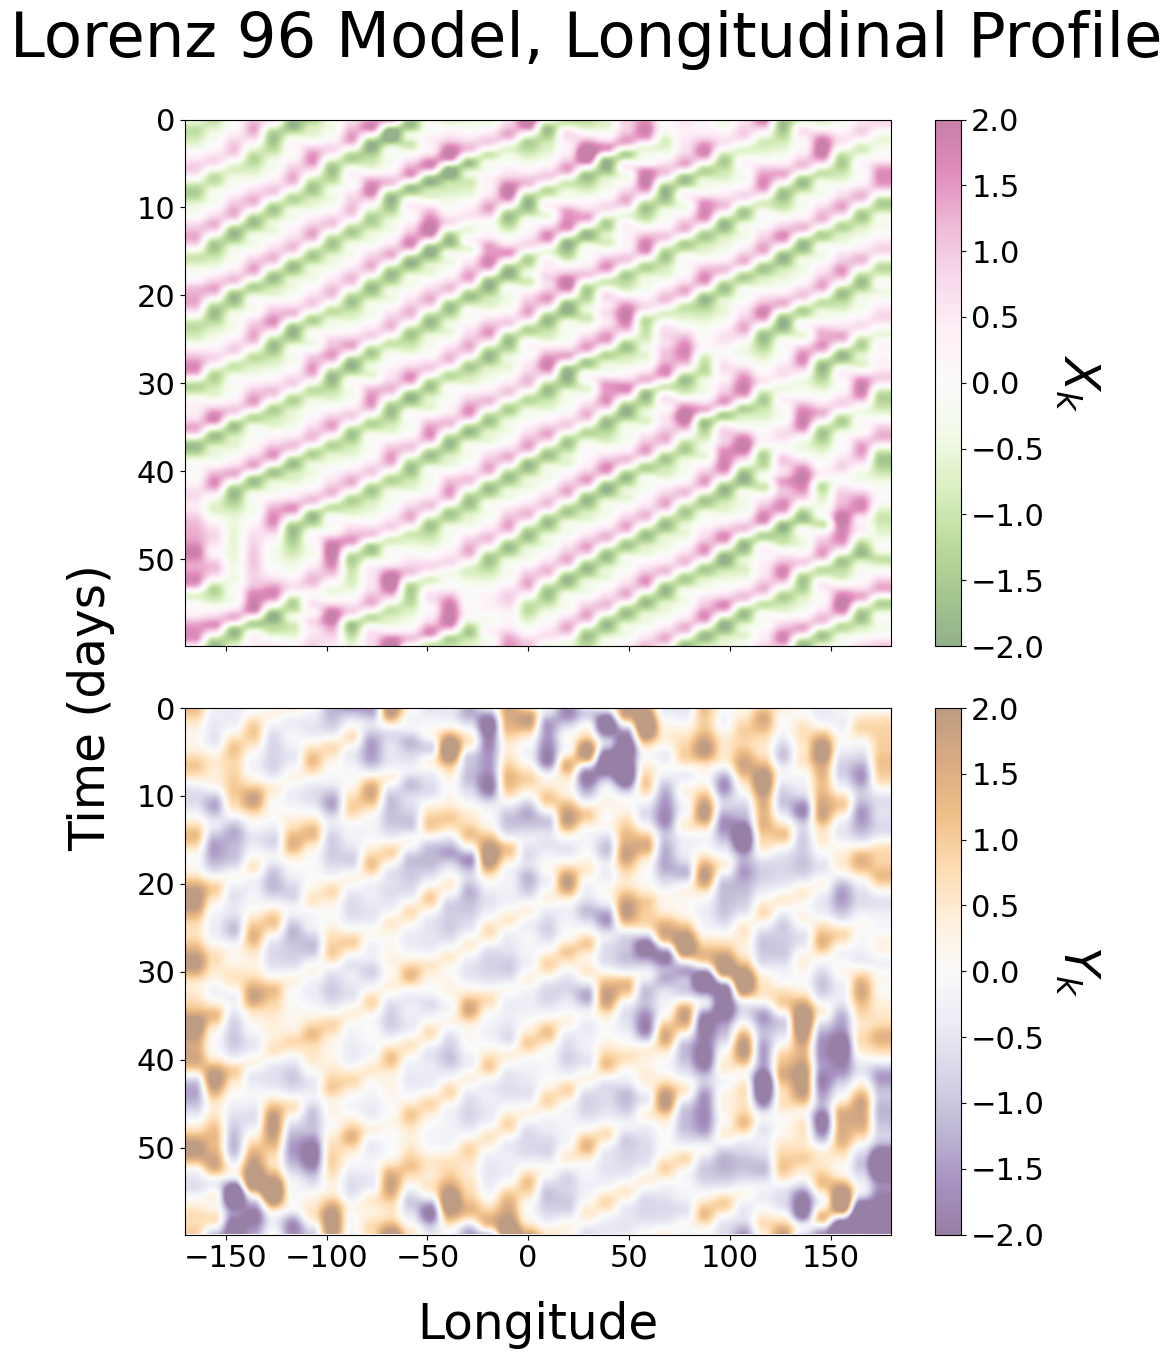

In [ ]:
# plot original lorenz data 
plot_longitudinal(
    state=state_x1x2similar, 
    config=config_x1x2similar, 
    version="target", 
    plot_ith_rollout_step=0, 
    plot_mode="val", 
    datasets=datasets_x1x2similar, 
    plot_days=60)

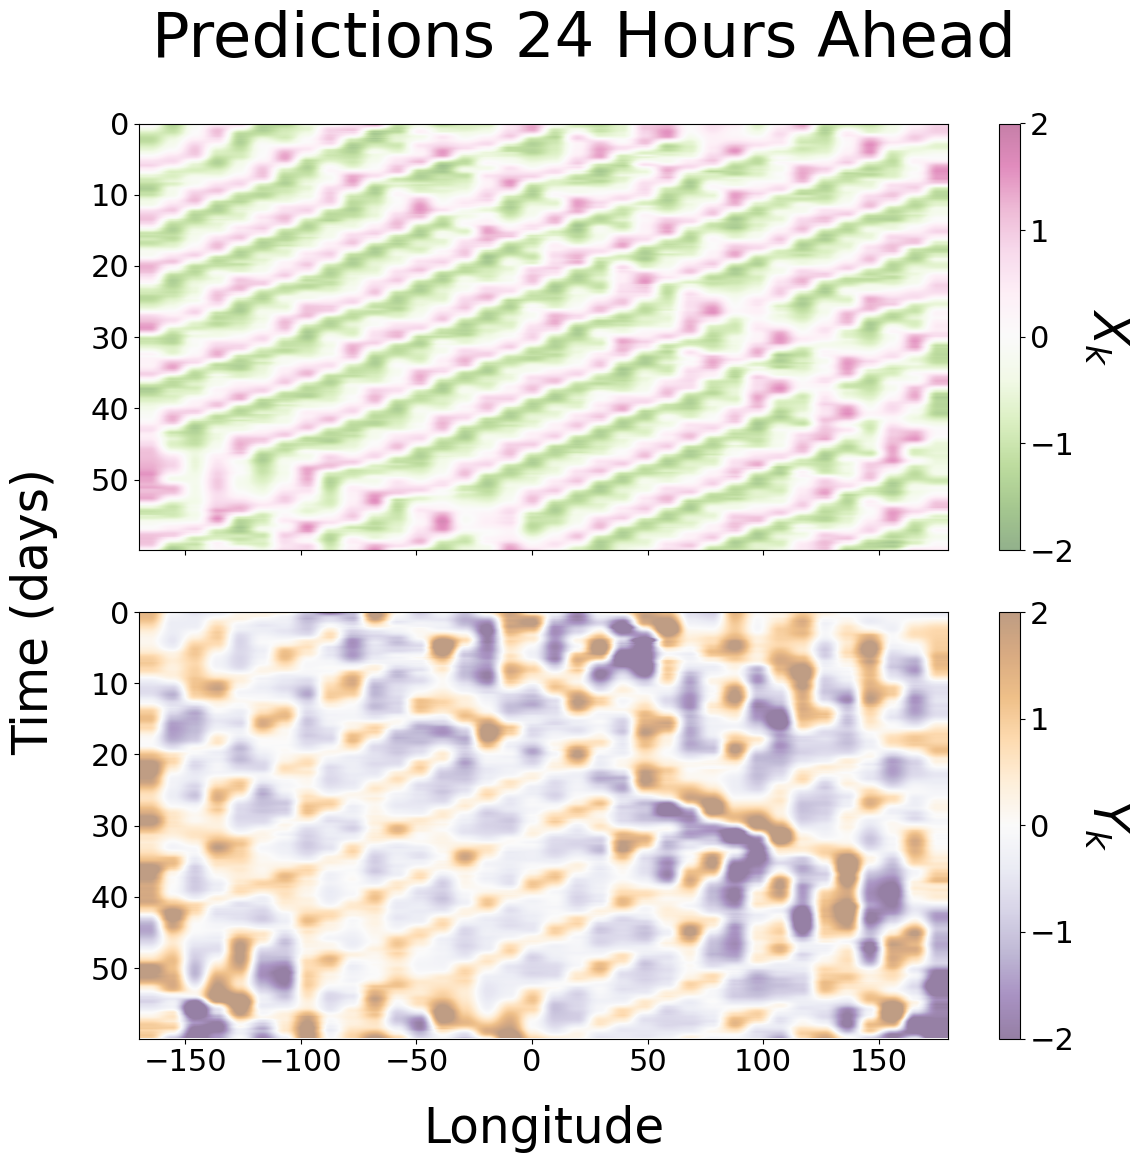

In [ ]:
# plot predictions
plot_longitudinal(
    state=state_x1x2similar, 
    config=config_x1x2similar, 
    version="predicted", 
    plot_ith_rollout_step=0, 
    plot_mode="val", 
    datasets=datasets_x1x2similar, 
    plot_days=60,
    title='Predictions 24 Hours Ahead')

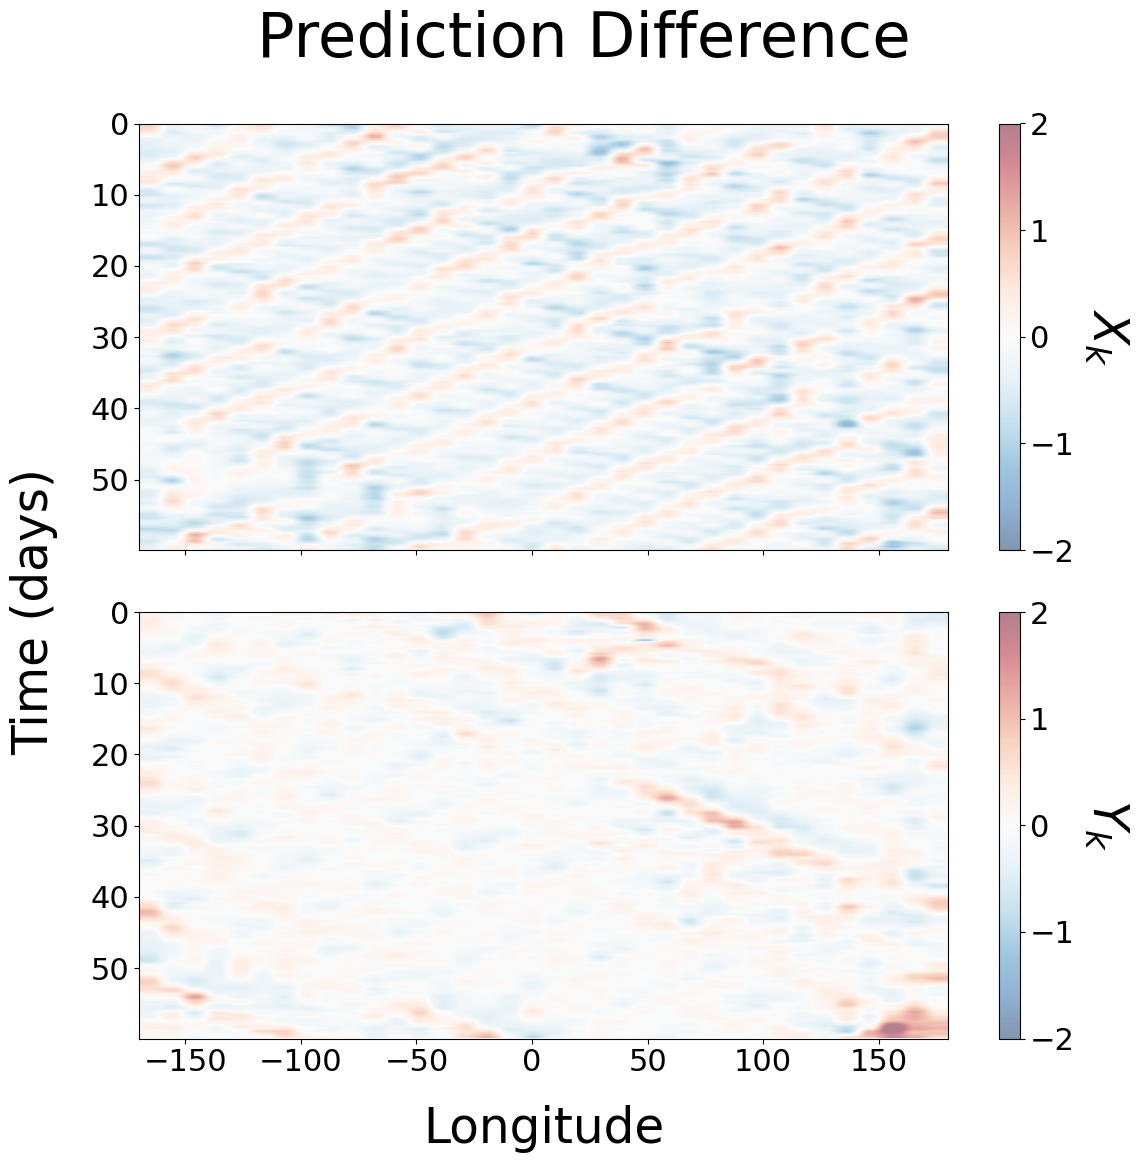

In [ ]:
# plot diff
plot_longitudinal(
    state=state_x1x2similar, 
    config=config_x1x2similar, 
    version="diff", 
    plot_ith_rollout_step=0, 
    plot_mode="val", 
    datasets=datasets_x1x2similar, 
    plot_days=60,
    title="Prediction Difference")

plots for the 4th rollout step

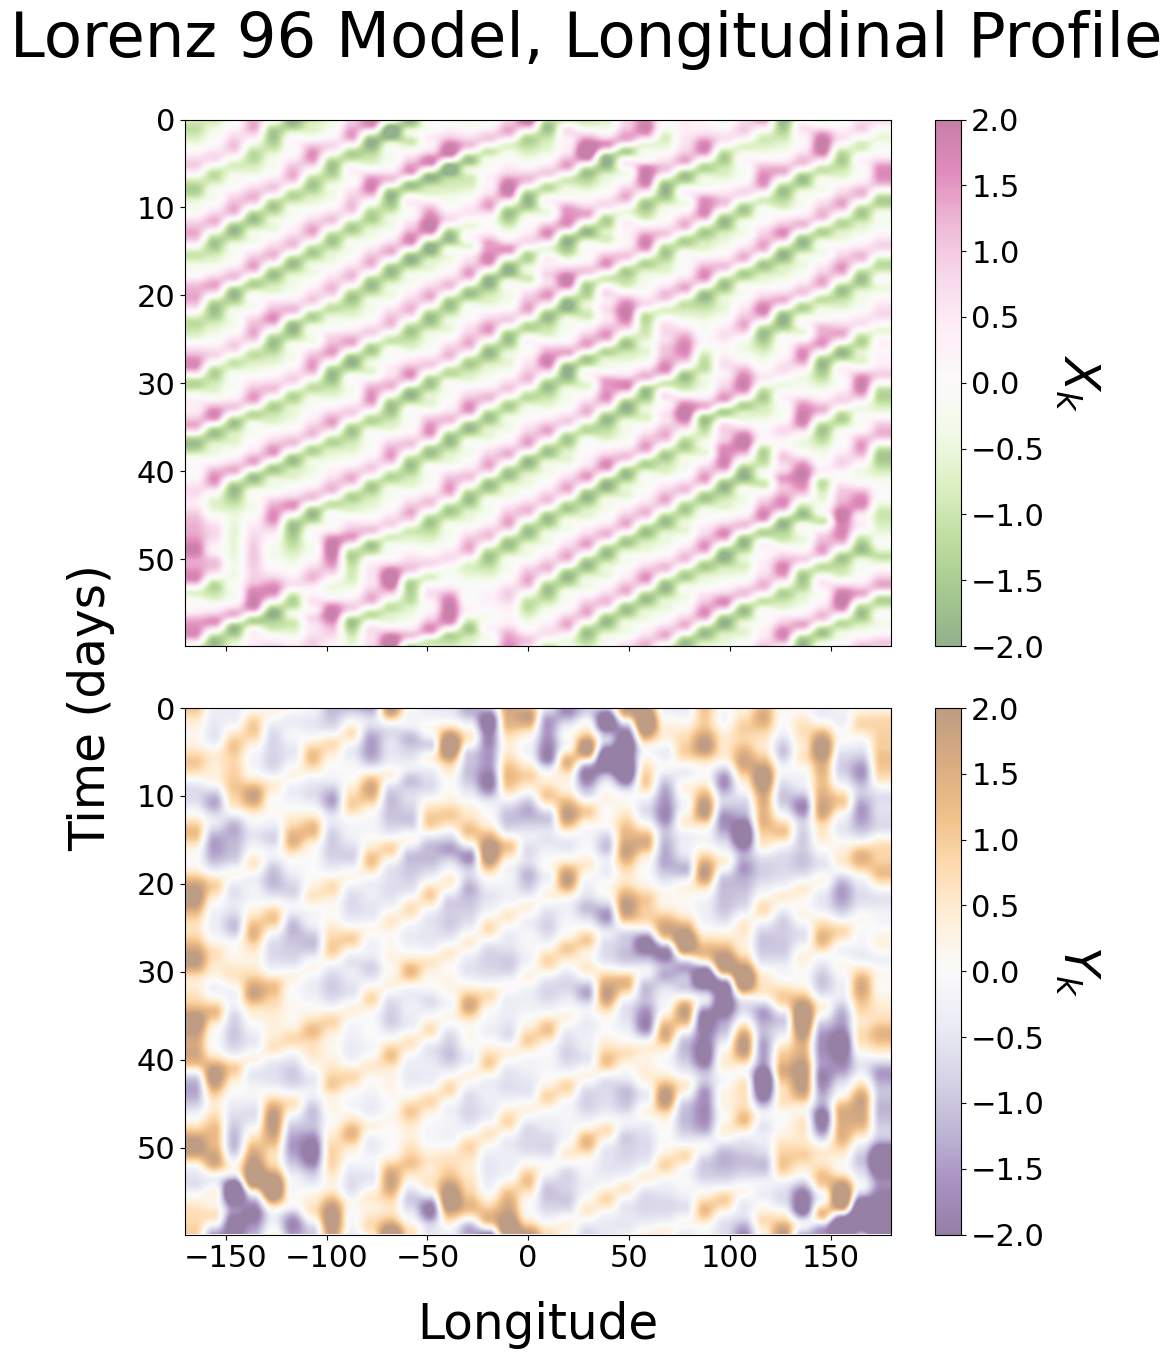

In [ ]:
# plot target
plot_longitudinal(
    state=state_x1x2similar, 
    config=config_x1x2similar, 
    version="target", 
    plot_ith_rollout_step=3, 
    plot_mode="val", 
    datasets=datasets_x1x2similar, 
    plot_days=60)

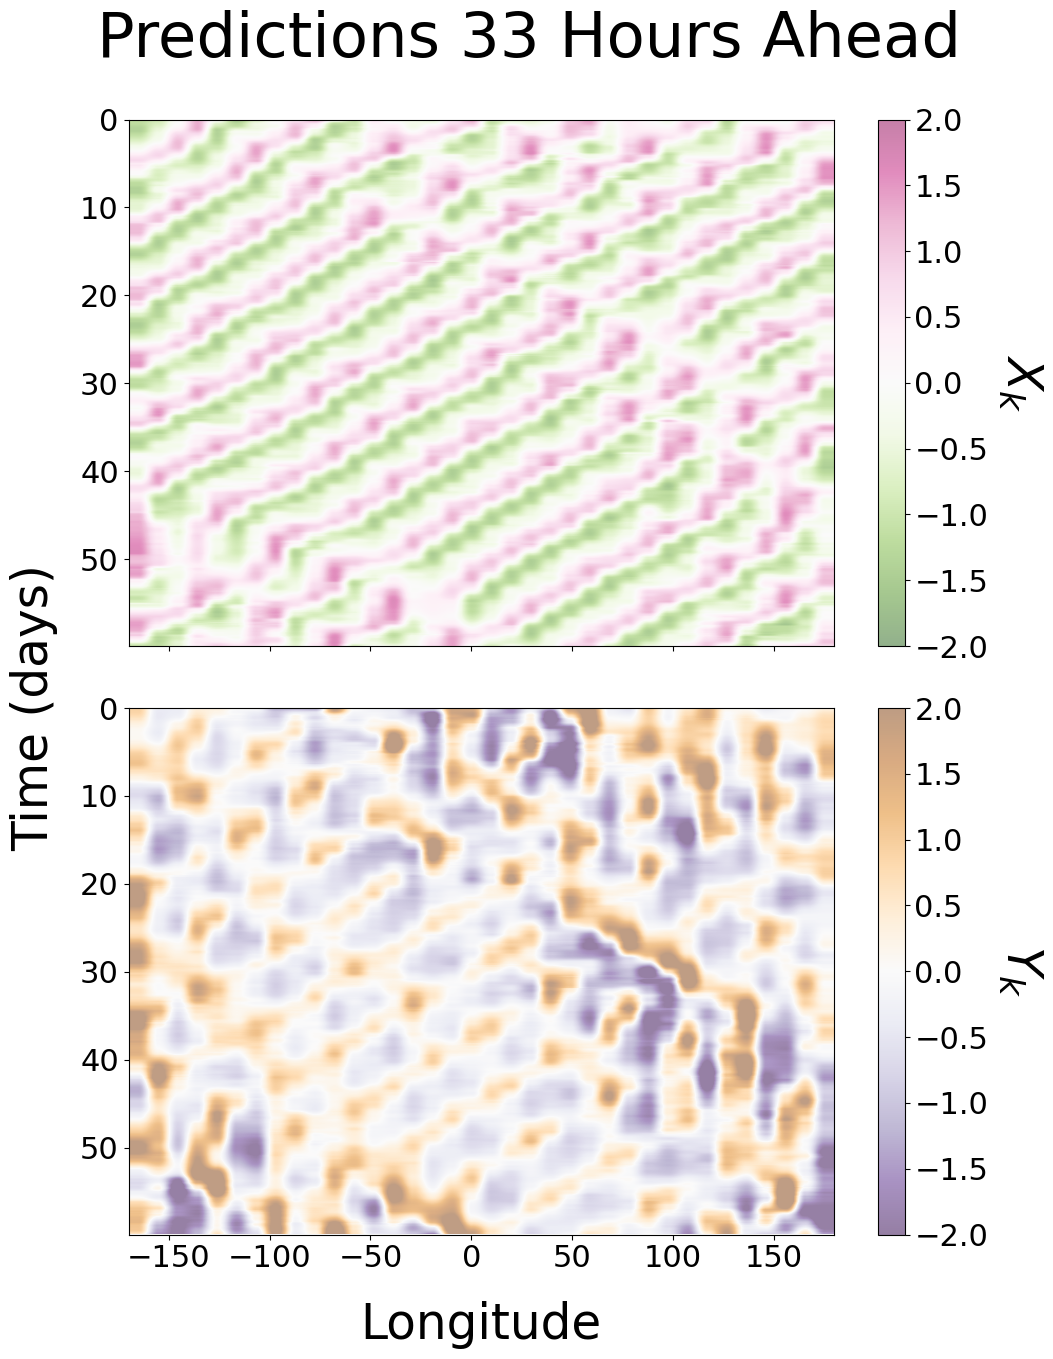

In [ ]:
# plot predictions
plot_longitudinal(
    state=state_x1x2similar, 
    config=config_x1x2similar, 
    version="predicted", 
    plot_ith_rollout_step=3, 
    plot_mode="val", 
    datasets=datasets_x1x2similar, 
    plot_days=60,
    title='Predictions 33 Hours Ahead')

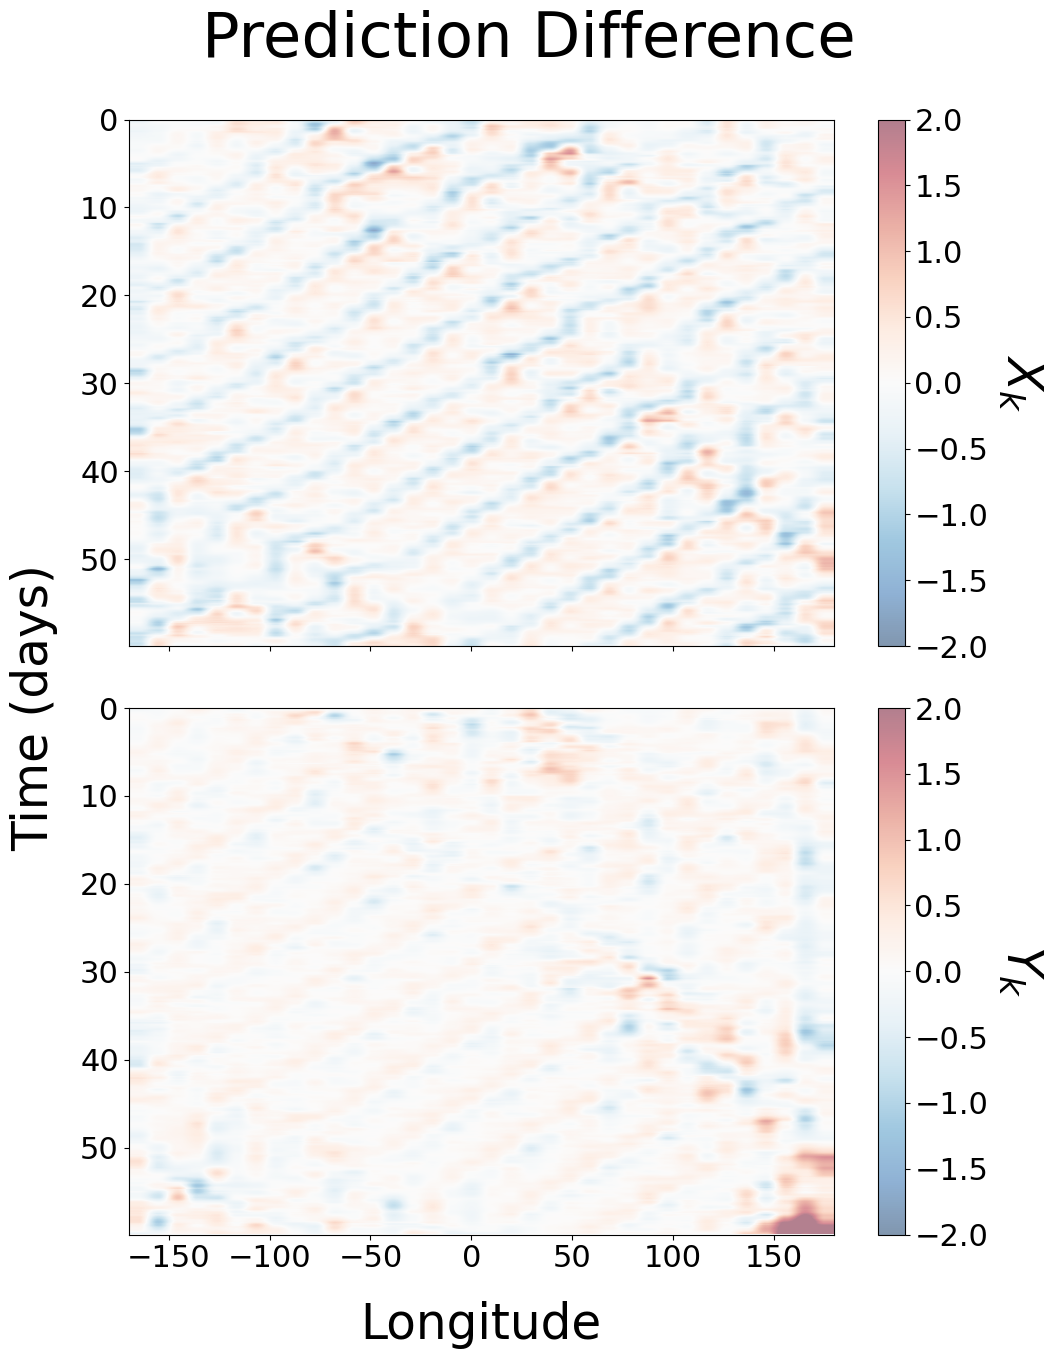

In [ ]:
# plot diff
plot_longitudinal(
    state=state_x1x2similar, 
    config=config_x1x2similar, 
    version="diff", 
    plot_ith_rollout_step=3, 
    plot_mode="val", 
    datasets=datasets_x1x2similar, 
    plot_days=60,
    title="Prediction Difference")

### rollout plot

In [ ]:
def plot_rollout(    
    state, 
    config, 
    # version, 
    # rollout_steps, 
    plot_mode, 
    node,
    input_window_idx, # which window in the whole time series to plot the rollout for 
    datasets, 
    plot_days):
    assert plot_mode in ["train", "val", "test"]

    # set up data 
    plot_set = datasets[plot_mode]
    input_data = plot_set['inputs']
    target_data = plot_set['targets']

    # reconstruct timesteps
    rollout_steps = int(plot_days * config.time_resolution / 5 / config.timestep_duration)
    t_days = np.arange(rollout_steps) * config.timestep_duration * 5 / config.time_resolution 

    input_window_graphs = input_data[input_window_idx]
    pred_nodes_rollout = rollout(state=state,
                                input_window_graphs=input_window_graphs,
                                n_rollout_steps=rollout_steps,
                                rngs=None) # deterministic during eval
    node_rollout_pred = [
        pred_nodes[node, :] for pred_nodes in pred_nodes_rollout
    ]

    # reconstruct target 
    # this step is very hacky right now because if we want a rollout longer than our configuration's output steps variable, we have to stitch it together ourselves
    node_rollout_target = [
        target_window_graphs[0].nodes[node, :] for target_window_graphs in target_data[input_window_idx:input_window_idx+rollout_steps]
    ] # take the first data point in each target window. we assume these are consecutive/overlapping windows. then get the node array from the graph. then index only the features for the desired node. 

    node_rollout_pred = np.vstack(node_rollout_pred)
    node_rollout_target = np.vstack(node_rollout_target)

    # set up plot
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(18, 10), sharex=True)
    fig.suptitle(f"{plot_mode} rollout predictions for node {node}", size=45)
    ax0.set_title("X", size=35)
    ax1.set_title("Y", size=35)
    plt.xlabel('Time (days)', size=35, labelpad=30)

    # plot rollout targets
    ax0.plot(t_days,
            node_rollout_target[:, 0],
            # s=5,
            alpha=0.8,
            label='Target',
            c='blue')
    ax1.plot(t_days,
            node_rollout_target[:, 1], 
            alpha=0.8, 
            label='Target', 
            c='blue')

    # plot predictions
    ax0.plot(t_days,
            node_rollout_pred[:, 0],
            # s=5,
            alpha=0.8,
            label='Prediction',
            c='orange')
    ax1.plot(t_days,
            node_rollout_pred[:, 1],
            # s=5,
            alpha=0.8,
            label='Prediction',
            c='orange')

    ax0.legend(loc="upper right")
    # ax1.legend(loc="upper left")

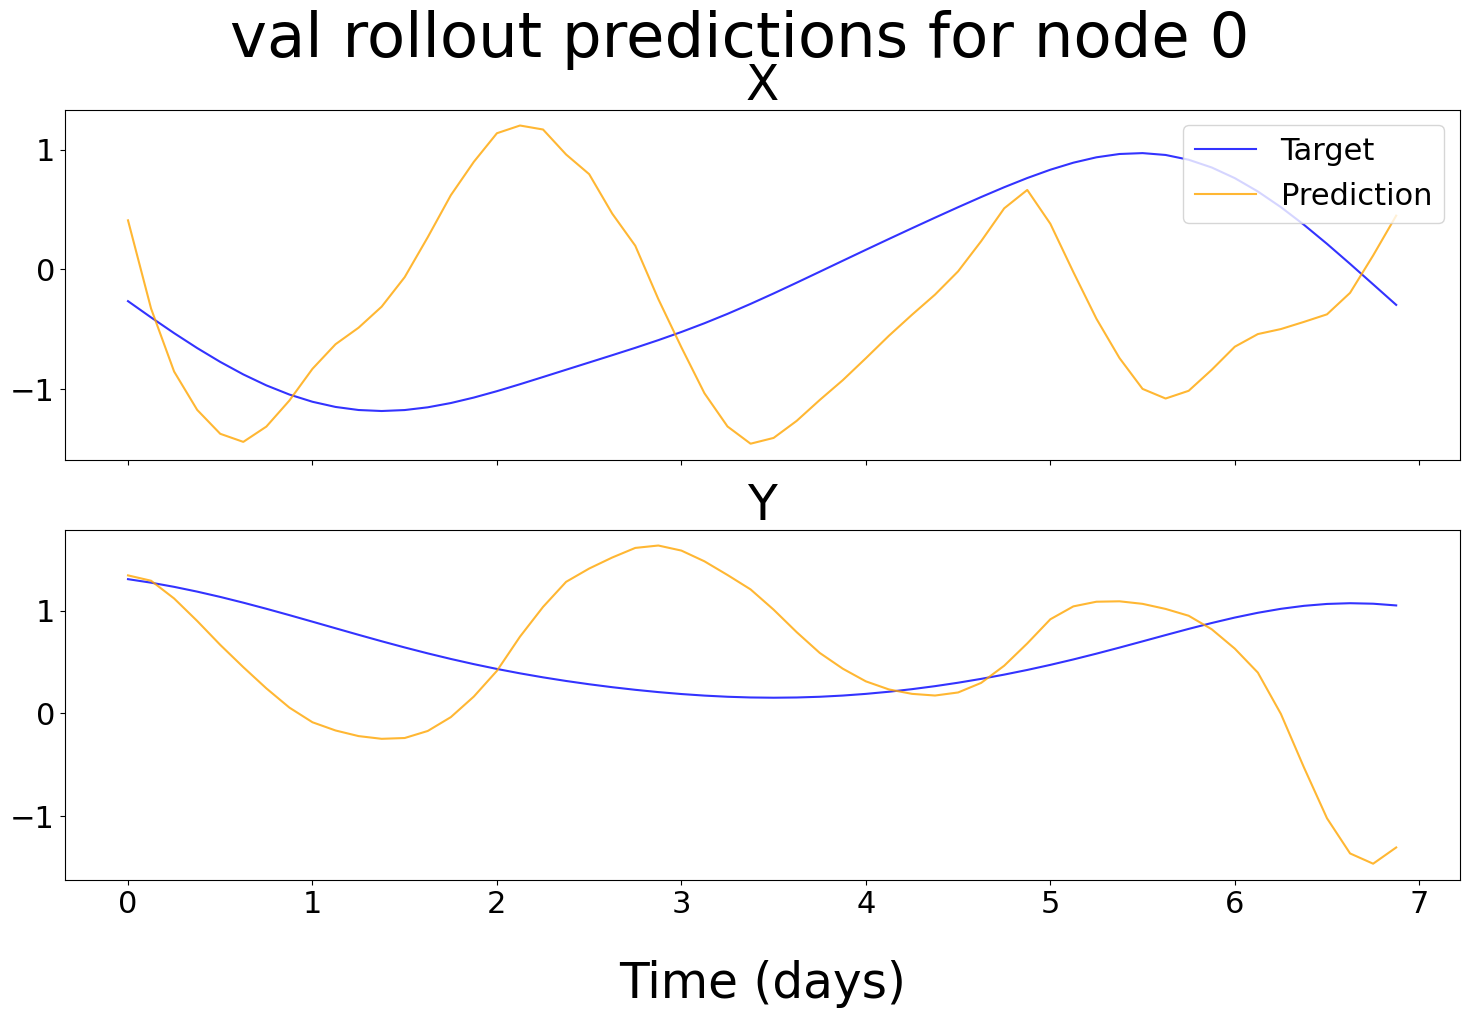

In [ ]:
plot_rollout(    
    state=state_x1x2similar, 
    config=config_x1x2similar, 
    plot_mode="val", 
    node=0,
    input_window_idx=0, # which window in the mode time series to plot the rollout for 
    datasets=datasets_x1x2similar, 
    plot_days=7,
)